![Cancer](https://media2.giphy.com/media/sCqnpiUFN228E/giphy.gif)

# Introduction

Among the most important areas in the world is human health. Exploring the methods for preventing and detecting health problems has sparked a lot of interest. Cancer is the most common illness that has a significant impact on human health. A malignant tumor is a cancerous tumor that develops as a result of the disease. Colon cancer, together with breast cancer and lung cancer, is the third most deadly disease in the United States, killing 49,190 people in 2016 [1]. This is a cancer that begins in the large intestine colon, which is the last component of the digestive system.

The machine learning technique should be used in this assignment to aid in the detection of malignant cells and the differentiation of cell types in colon cancer. Deep learning algorithms such as AlexNet, Resnet50, and VGG19 will all be developed and evaluated in this notebook, with XGBoost being the sole non-deep learning option to tackle the issue.

# Import necessary library

In [73]:
conda install -c conda-forge keras-preprocessing


Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [76]:
pip install tensorflow

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.utils import resample

import seaborn as sns
import warnings

from tensorflow.keras.layers.experimental import preprocessing



from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

## Load dataset

In [78]:
df_label = pd.read_csv("data_labels_mainData.csv")
df_label_extra = pd.read_csv("data_labels_extraData.csv")

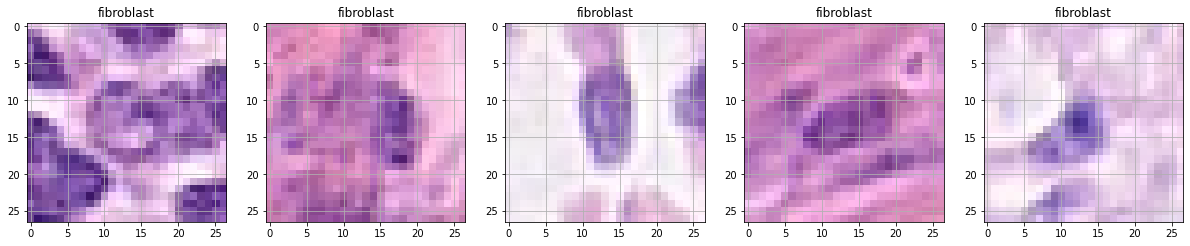

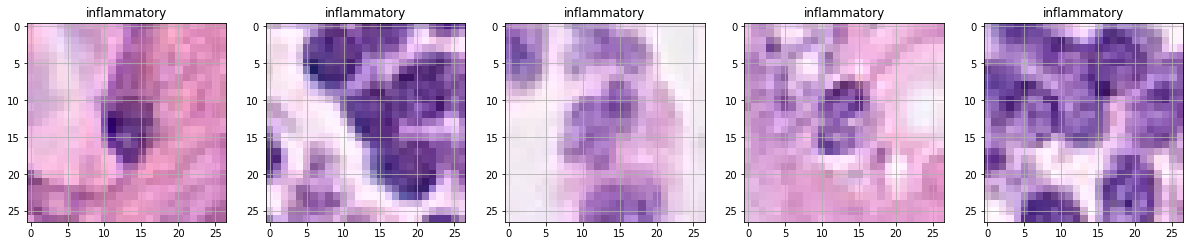

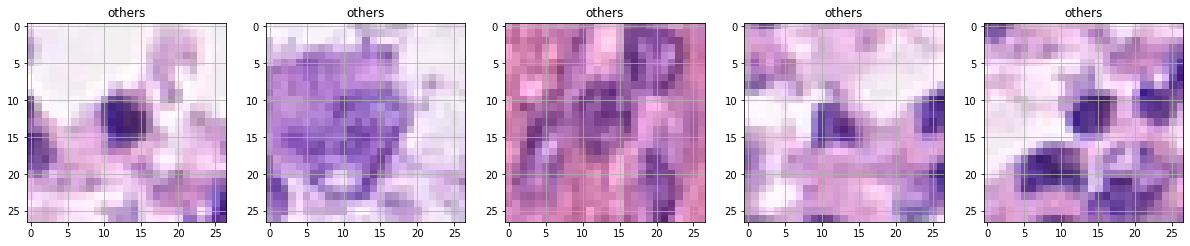

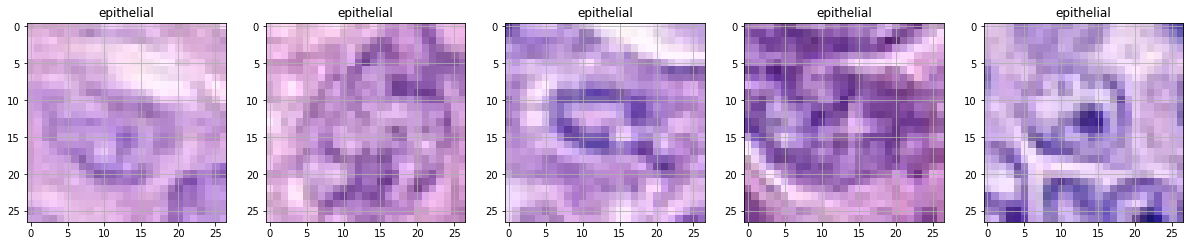

In [79]:
from tensorflow.keras.preprocessing import image

CELL_TYPE_SAMPLE_SIZE = 5

for cell_type_name in df_label['cellTypeName'].unique():
    df_sample = df_label[df_label['cellTypeName'] == cell_type_name].sample(CELL_TYPE_SAMPLE_SIZE)
    plt.figure(figsize=(CELL_TYPE_SAMPLE_SIZE ** 2, CELL_TYPE_SAMPLE_SIZE))
    for image_index, image_name in enumerate(df_sample['ImageName']):
        plt.subplot(1, CELL_TYPE_SAMPLE_SIZE + 1, image_index+1)
        plt.grid(None)
        img = image.load_img('./patch_images/' + image_name, target_size=(27, 27))
        plt.imshow(img)
        plt.title(cell_type_name)

## *Task1: Classify  images  according  to  whether  given  cell  image  represents  a cancerous cells or not (isCancerous)*

# Data Processing 


In [80]:
is_cancer_class_count = df_label.isCancerous.value_counts()
amount_for_balance = abs(is_cancer_class_count[0] - is_cancer_class_count[1])
df_random_cancer_from_extra = df_label_extra[df_label_extra['isCancerous'] == 1].sample(amount_for_balance)
df_label = pd.concat([df_label, df_random_cancer_from_extra], ignore_index=True)
df_label.isCancerous.value_counts()

0    5817
1    5817
Name: isCancerous, dtype: int64

In [81]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_label, test_size=0.2, random_state=9999)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=9999)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Train data : 6980, Val Data: 2327, Test Data: 2327


In [82]:
# document: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
from keras_preprocessing.image import ImageDataGenerator

def get_dataframe_iterator(dataframe, 
                            image_shape = (27, 27), 
                            batch_size = 64,
                            x_col = "ImageName",
                            y_col = "cellTypeName",
                            classes = ["fibroblast", "inflammatory", "epithelial", "others"]):
    dataframe[y_col] = dataframe[y_col].apply(str)
    generator = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) 
    iterator = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = "./patch_images", 
        x_col = x_col,
        y_col = y_col,
        classes = classes, 
        class_mode = "categorical", 
        target_size = image_shape, 
        batch_size = batch_size,
    )
    return iterator

In [83]:
# Check duplicate

In [84]:
import os
file_list = os.listdir('./patch_images/')
print(len(file_list))

20280


In [85]:
import hashlib, os
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('./patch_images/')):  #listdir('.') = current directory

    if os.path.isfile('./patch_images/'+filename):
        with open('./patch_images/'+filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))
            print(filename)


15848.png
18581.png
4971.png


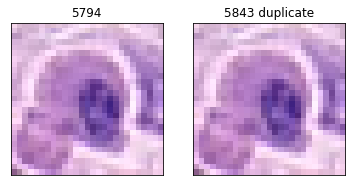

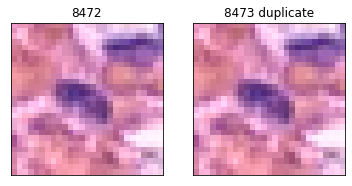

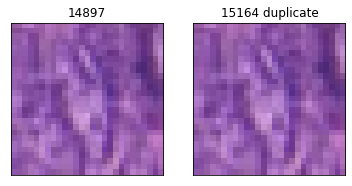

In [86]:
from imageio import imread
for file_indexes in duplicates[:30]:
    try:
    
        plt.subplot(121),plt.imshow(imread('./patch_images/'+ file_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread('./patch_images/'+ file_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

In [87]:
# Remove duplicate
for index in duplicates:
#     os.remove('./patch_images/' + file_list[index[0]] )
    print('./patch_images/' + file_list[index[0]] )

./patch_images/15848.png
./patch_images/18581.png
./patch_images/4971.png


In [88]:
print(df_label)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
11629       14475         66  14475.png          NaN       NaN            1
11630       10386         70  10386.png          NaN       NaN            1
11631        9768         86   9768.png          NaN       NaN            1
11632       11635         65  11635.png          NaN       NaN            1
11633        7658         88   7658.png          NaN       NaN            1

[11634 rows x 6 columns]


In [89]:
for index in duplicates:
    print(index[0])
    df_label = df_label[df_label.ImageName  != file_list[index[0]]]

5843
8473
15164


In [90]:
print(df_label)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
11629       14475         66  14475.png          NaN       NaN            1
11630       10386         70  10386.png          NaN       NaN            1
11631        9768         86   9768.png          NaN       NaN            1
11632       11635         65  11635.png          NaN       NaN            1
11633        7658         88   7658.png          NaN       NaN            1

[11631 rows x 6 columns]


In [91]:
is_cancer_class_count = df_label.isCancerous.value_counts()
amount_for_balance = abs(is_cancer_class_count[0] - is_cancer_class_count[1])
df_random_cancer_from_extra = df_label_extra[df_label_extra['isCancerous'] == 1].sample(amount_for_balance)
df_label = pd.concat([df_label, df_random_cancer_from_extra], ignore_index=True)
df_label.isCancerous.value_counts()

1    5817
0    5815
Name: isCancerous, dtype: int64

In [92]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_label, test_size=0.2, random_state=9999)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=9999)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Train data : 6978, Val Data: 2327, Test Data: 2327


In [93]:
# document: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
from keras_preprocessing.image import ImageDataGenerator

def get_dataframe_iterator(dataframe, 
                            image_shape = (27, 27), 
                            batch_size = 64,
                            x_col = "ImageName",
                            y_col = "cellTypeName",
                            classes = ["fibroblast", "inflammatory", "epithelial", "others"]):
    dataframe[y_col] = dataframe[y_col].apply(str)
    generator = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) 
    iterator = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = "./patch_images", 
        x_col = x_col,
        y_col = y_col,
        classes = classes, 
        class_mode = "categorical", 
        target_size = image_shape, 
        batch_size = batch_size,
    )
    return iterator

In [94]:
train_iterator = get_dataframe_iterator(train_df, y_col='isCancerous', classes=['0','1'])
val_iterator = get_dataframe_iterator(val_df, y_col='isCancerous', classes=['0','1'])
test_iterator = get_dataframe_iterator(test_df, y_col='isCancerous', classes=['0','1'])

Found 6978 validated image filenames belonging to 2 classes.
Found 2327 validated image filenames belonging to 2 classes.
Found 2327 validated image filenames belonging to 2 classes.


In [95]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Add
from keras import regularizers
from keras import Input
from tensorflow.keras import initializers
from keras.initializers import GlorotUniform

from keras import Model
from keras import backend as K

In [96]:
def fit_model(model, iterator, val_iterator, 
              epochs = 100, 
              export_dir = './export',
              name = 'default'):
    es = EarlyStopping(monitor='val_accuracy', 
                       mode='max', 
                       verbose=1, 
                       patience=10, 
                       restore_best_weights=True)
    mc = ModelCheckpoint('{}/model_{}.h5'.format(export_dir, name), 
                         monitor='val_accuracy', 
                         mode='max', 
                         save_best_only=True)

    history = model.fit_generator(
        iterator,
        validation_data = val_iterator,
        epochs = epochs,
        verbose = 1,
        callbacks=[mc,es]
    )
    return history

In [97]:
import cv2
import os
list_of_images = []

for path in df_label['ImageName']:
  image_path = os.path.join("./patch_images", path)
  image = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
  list_of_images.append(image)

list_of_images = np.asarray(list_of_images)
np.array(list_of_images).shape

(11632, 27, 27)

In [98]:
list_of_images = np.reshape(list_of_images,  (-1 , 27 * 27))
list_of_images = pd.DataFrame(list_of_images)

In [99]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

cancer_training_X , cancer_test_X, cancer_training_Y , cancer_test_Y = train_test_split(list_of_images, df_label['isCancerous'], train_size = 0.8 , random_state = 9999, shuffle = True)

print("Training X shape: " , cancer_training_X.shape)
print("Training Y shape: " , cancer_training_Y.shape)
print("Testing X shape: " , cancer_test_X.shape)
print("Testing Y shape: " , cancer_test_Y.shape)

Training X shape:  (9305, 729)
Training Y shape:  (9305,)
Testing X shape:  (2327, 729)
Testing Y shape:  (2327,)


In [104]:
# https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate
from keras.layers.merge import concatenate

## XGBoost

## InceptionV3

In [100]:
!pip install keras_vggface

In [101]:
import keras
!pip install keras_applications
from keras_applications.imagenet_utils import _obtain_input_shape

In [102]:
from tensorflow import keras
from tensorflow.python.util import tf_inspect
from keras.applications.inception_v3 import InceptionV3

In [106]:
model_inceptionv3 = InceptionV3(include_top=False,
                              weights = 'imagenet')

87924736/87910968 [==============================] - 11s 0us/step


In [108]:

model_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [112]:
opt = Adam(lr=0.0045 , amsgrad = True)
model_inceptionv3.compile(optimizer=opt, loss='binary_crossentropy')

history_inception_v3 = fit_model(model_inceptionv3, train_iterator, val_iterator, 
                                export_dir='.',
                                name="Resnet50_Task1")

Epoch 1/100


KeyboardInterrupt: 

# GoogleNet

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (27, 27, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  X = ZeroPadding2D(padding=(10, 10))(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 1)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(2, activation = 'softmax')(X1) # <----- changed 1000 to 2

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(2, activation = 'softmax')(X2) # <----- changed 1000 to 2
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(2, activation = 'softmax')(X) # <------ changed from 1000 to 2 
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
model_googlenet_t1 = GoogLeNet()

In [ ]:
from tensorflow.keras.utils import plot_model

model_googlenet_t1.summary()

In [ ]:
plot_model(model_googlenet_t1, show_shapes=True)

In [ ]:
opt = Adam(lr=0.00045, amsgrad = True)
model_googlenet_t1.compile(optimizer=opt, loss='binary_crossentropy')

history_googlenet_t1 = fit_model(model_googlenet_t1, train_iterator, val_iterator,
                                export_dir='.',
                                name="GoogLeNet_Task1")

In [ ]:
evaluation_googlenet_t1 = model_googlenet_t1.evaluate(test_iterator)

In [ ]:
evaluation_googlenet_t1 = [
    evaluation_googlenet_t1[1], # dense_4_loss
    evaluation_googlenet_t1[4], # dense_4_accuracy
    evaluation_googlenet_t1[5], # dense_4_precision
    evaluation_googlenet_t1[6], # dense_4_recall
    evaluation_googlenet_t1[7]  # dense_4_f1
]

## *Task2: Classify  images  according  to  cell-type,  such  as:  fibroblast,  inflammatory, epithelial or others* 

<a id ="IV"></a>
<h2 style = "text-align:center; color:white; font-weight:600; padding:0.5em; background-color: #B02B00; border-radius:25px ; box-shadow: 0 0 20px 0 #ACA7CB; margin-right:3em; margin-bottom:1em">â… . Cleaning dataset  </h2>

#### Before cleaning the data, let display the dataset to observe it in general

In [ ]:
df_label

<a id ="IV.A1"></a>

### *1. Check Data type*

In [ ]:
## read all info row by row
df_label.info()

### ðŸ“š Reason: 
We need to check data type for overall understanding for our dataset and identifying which column we should keep or change data type for later encoding and better model's performance

<a id ="IV.A2"></a>

### *2. Checking missing values*

### ðŸ“š Reason: 
Missing value can lead to error for machine, thus, we need to check if there is any missing value and fill it.

In [ ]:
# Check if the dataset has any missing value, 
df_label.isnull().values.any()

### ðŸ”¬ Observation: 
Since the return value is false, we can conclude that the dataset has no missing values. However, we should double check for every columns

In [ ]:
# Check total missing values for each columns 
df_label.isnull().sum()

### ðŸ”¬ Observation: 
There is 100% no missing values in any columns in the dataset, thus, we dont not need to fill any missing values for this dataset

<a id ="IV.A3"></a>

### *3. Check typography*

In [ ]:
celltype_name_values = df_label['cellTypeName'].nunique(dropna=False)
print(celltype_name_values)

In [ ]:
print(df_label['cellTypeName'].unique())

### ðŸ“š Reason: 
Typo value can lead to time runing and storage problem for machine (fibroblast, fibreblast are 2 different values but have same meaning), thus, we check typo preventing same meaningful values

### ðŸ”¬ Observation: 
Since the cellTypeName column have 4 different values such as fibroblast, inflammatory, epithelial or others. => no typo

<a id ="IV.A4"></a>

### *4. Convert string column to uppercase*

### ðŸ”¬ Observation: 
Since there are only 4 values fibroblast, inflammatory, epithelial in cellTypeName columns. Therefore, we do not need to convert to lowercase or uppercase for this dataset. However, in the larger dataset with multiple values, we should convert to all uppercase or lowercase to avoid duplication 

<a id ="IV.A5"></a>

### 5. Eliminate extra white spaces 

### ðŸ”¬ Observation: 
Since the Sepsis column have 4 different values such as fibroblast, inflammatory, epithelial or others => no extra white spaces    

<a id ="IV.A6"></a>

### *6. Check duplication*

In [ ]:
# Empty Datafrane -> no dupplication in the df_label dataframe
duplicate_values = df_label[df_label.duplicated()]
print(duplicate_values)

### ðŸ“š Reason: 
Duplicate data can lead to time runing and storage problem for machine, thus, we need to check if there is any duplicated data and drop it.

### ðŸ”¬ Observation: 
There is 100% no duplicated values in the dataset, thus, we dont not need to drop any rows for this dataset

<a id ="IV.A7a"></a>

### 7. Check impossible values 

### ðŸ“š Reason: 
Some time the dataset has some impossible values such as age is negative, thus, we need to check impossible value to find and drop or fix it to improve the accuracy of the machine learing

### ðŸ”¬ Observation: 
In this dataset, all of the data are reasonable => no impossible values

<a id ="IV.B8"></a>

### 8. Check outlier 

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7.5]
# plot the boxplot to see the outlier of each numerical column
sns.boxplot(data=df_label,orient="v")
plt.title("Bot-Plots Distribution", y = 1,fontsize = 20, pad = 40);

### ðŸ”¬ Observation:
According to the bot-plots, there are completely no outliner in this dataset

In [ ]:
df_label.head(20)

### ðŸ“š Reason: 
After finish cleaning the data, we should display the data to double check the data and figure out the count, mean, min , 25%, 50%, 75%, max to prepare for EDA step in later section.

<a id ="VI"></a>

<h2 style = "text-align:center; color:white; font-weight:600; padding:0.5em; background-color: #B02B00; border-radius:25px ; box-shadow: 0 0 20px 0 #ACA7CB; margin-right:3em; margin-bottom:1em">II. Exploratory Data Analysis (EDA)
</h2>

<a id ="V.1"></a>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">1.My hypothesises </h3>

1. The value for each type in the cell type name will be different.

2. The value of `others` class will be the least compare to other classes.


In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
titanic = sns.load_dataset("titanic")
ax = sns.countplot(y="cellTypeName", data=df_label)
ax.set_title("Bar chart to display the total number of each type in cell type name", fontsize=15)
for bars in ax.containers:
    ax.bar_label(bars)
    

In [ ]:
### ðŸ”¬ Observation: 
In this plot, the vertical axis is cellTypeName and the horizontal axis is count (total values). In overall, the class epithelial has the most value (4079) whereas the other class have the least value (1386). In additional, the different between each class are large, thus, we should consider to solve this problem by using imbalance in the feature engineering step. 

After observation, we can conclude that our hypotheses are correct.

<a id ="VI"></a>

<h2 style = "text-align:center; color:white; font-weight:600; padding:0.5em; background-color: #B02B00; border-radius:25px ; box-shadow: 0 0 20px 0 #ACA7CB; margin-right:3em; margin-bottom:1em">III. Feature Enginnering</h2>

<a id ="VI.1"></a>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">1.Drop Unrealated columns to the target</h3>

### ðŸ”¬ Observation: 
Since all columns in the dataset are neccessary => we do not need to drop any columns

<a id ="VI.2"></a>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">2.Class Imbalances</h3>

In [ ]:
print(df_label['cellTypeName'].value_counts())
print(df_label['cellTypeName'].value_counts(normalize=True, dropna=False))

### ðŸ“š Reason: 
The reason, we need to rebalance these classes value is the accuracy of the sepsis prediction might affected by the amount of values in one class. In other words , if one class has more values compare to the others , it is likely that we will receive the better prediction for this class instead of others, thus, the prediction for other clas might be worst. Thus,in this particular situation, since the difference between these classes are large, we can rebalance these classes using <strong>upsample method</strong>

### ðŸ”¬ Observation: 
Since the value for each cell type are extremely different from others (4079, 2543 , 1888 , 1386). Thus, we need to rebalance these classes. 

In [ ]:
def resampleData (minority_value):
    return resample(minority_value,
                                 replace=True,     # sample with replacement
                                 n_samples=4079,    # to match majority class
                                 random_state=123) # reproducible results

In [ ]:
# Separate 2 classes depend all total values
majority_value = df_label[df_label.cellTypeName=="epithelial"]
minority_value = df_label[df_label.cellTypeName=="inflammatory"]
minority_value2 = df_label[df_label.cellTypeName=="fibroblast"]
minority_value3 = df_label[df_label.cellTypeName=="others"]
 
# Balance majority value with upsampled minority value
df_label_balanced = pd.concat([majority_value, resampleData(minority_value),
                               resampleData(minority_value2),
                               resampleData(minority_value3)])
 
# Show new value in these classes
df_label_balanced.cellTypeName.value_counts()

### ðŸ”¬ Observation: 
After upsampling these classes, the value for all classes are the same, thus, we can move to the next step.

<a id ="VII"></a>
<h2 style = "text-align:center; color:white; font-weight:600; padding:0.5em; background-color: #B02B00; border-radius:25px ; box-shadow: 0 0 20px 0 #ACA7CB; margin-right:3em; margin-bottom:1em">IV. Model Building</h2>

<a id ="VII.1"></a>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">1.Split dataframe </h3>

In [ ]:
train_df_bl, test_df_bl = train_test_split(np.array(df_label_balanced), test_size=0.2, random_state=42)
train_df_bl, val_df_bl = train_test_split(np.array(train_df), test_size=0.2, random_state=42)
print(train_df_bl.shape)`
print(test_df_bl.shape)
print(val_df_bl.shape)

### ðŸ”¬ Observation: 
After spliting the data, we can start training the models 

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">2. XG Boost</h3>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">3. Resnet</h3>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">4. GoogleNet</h3>

<h3 style = "color : #F06200; font-style:italic; letter-spacing:0.075em;">5. Alex Net</h3>